## Pain Score evaluation Segment level (Select pose)

In [1]:
from bsoid_kit import *
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt

### Bsoid model train (Clustering)

In [2]:
root = r'C:\Users\x\Desktop\final\bsoid\control'
outpath = r'./data/models'
landmarknum = 7
framerate = 200
embeder_name = r'./data/models/f20.embeder'
clf_name = r'./data/models/f20.clf'
shift = False
# embed
embeded = False
num_dimensions = 20
sel = []
# sel = np.array([ 5, 8, 10, 13, 14, 25, 26])
# cluster
min_c = 0.5 #for hdbscan
k = 15  #for others
cls_type = 'km'

In [3]:
# files = os.listdir(root)
# if not os.path.isdir(outpath):
#     os.makedirs(outpath)
# feats = []
# for file in files:
#     filename = root+'/'+file
#     feat = bsoidfeat(filename,landmarknum,framerate, shift=shift)
#     if len(feats)==0:
#         feats = feat
#     else:
#         feats = np.concatenate([feats, feat])
# joblib.dump(feats, r'C:\Users\x\Desktop\final\bsoid/feat')

In [4]:
feats = joblib.load(r'C:\Users\x\Desktop\final\bsoid/feat7')

In [5]:
if embeded:
    embeder, embeddings = embedfeat(feats, num_dimensions=num_dimensions, sel=sel, savename=embeder_name)
    motions = motion_cluster(embeddings, min_c, k, cls_type)
    clf = motion_clf(embeddings, motions, test_part=0.1, score=True, savename=clf_name, clf_type='rf')
else:
    motions = motion_cluster(feats, min_c, k, cls_type)
    clf = motion_clf(feats, motions, test_part=0.1, score=True, savename=clf_name, clf_type='svm')

[0.9296875  0.921875   0.91236307 0.91392801 0.92488263]


### BSOiD Feature extract with pose prediction save to file

In [11]:
root = r'../final_data/new_landmark7/'
outpath = r'../final_data/new_bsoidfeat/'
landmarknum = 7
framerate = 200
embeder_path = '' #r'../final_data/models/f20.embeder'
clf_path = r'../final_data/models/f20.clf'
shift = False

files = os.listdir(root)
if not os.path.isdir(outpath):
    os.makedirs(outpath)
for file in files:
    # if file.find('Cap')==-1:##################################
    #     continue##############################################
    filename = root+'/'+file
    savename = (outpath+'/'+file).replace('.csv','')
    if not os.path.isfile(clf_path): # save feat only
        feat = bsoidfeat(filename,landmarknum,framerate,savename,shift=shift)
    if os.path.isfile(embeder_path): # save feat, embeddings, motions
        if(os.path.isfile(savename)):
            sav = joblib.load(savename)
            feat = sav[0]
        else:
            feat = bsoidfeat(filename,landmarknum,framerate,shift=shift)
        embeder = joblib.load(embeder_path)
        clf = joblib.load(clf_path)
        embeddings = embeder.transform(feat)
        motions = motion_predict(feat, clf, embeder=embeder)
        motions_fs = []
        # motions_fs = bsoid_predict(filename, landmarknum, framerate, clf, embeder)
        joblib.dump([feat,embeddings,motions_fs,motions], savename)
    elif os.path.isfile(clf_path): # save feat, motions
        if(os.path.isfile(savename)):
            sav = joblib.load(savename)
            feat = sav[0]
        else:
            feat = bsoidfeat(filename,landmarknum,framerate,shift=shift)
        clf = joblib.load(clf_path)
        motions = clf.predict(feat)
        motions_fs = []
        # motions_fs = bsoid_predict(filename, landmarknum, framerate, clf)
        joblib.dump([feat,motions_fs,motions], savename)

### pose analysis function for Cap data

In [2]:
def get_ms(root, clf_path, score_type='clf', show=False, showplt=True):
    files = os.listdir(root)
    clf = joblib.load(clf_path)
    motion_num = len(clf.classes_)

    motionB = [0]*motion_num
    motionT = [0]*motion_num
    for file in files:
        if file.find('Cap')!=-1:
            savfile = joblib.load(root+'/'+file)
            labels = savfile[-1] # motions
            if file.find('basal')!=-1:
                for i in range(motion_num):
                    motionB[i]+= len(np.where(labels==i)[0])
            if file.find('treat')!=-1:
                for i in range(motion_num):
                    motionT[i]+= len(np.where(labels==i)[0])

    diff = np.array(motionT)-np.array(motionB)
    sum2 = np.array(motionT)+np.array(motionB)
    ratio = np.zeros((motion_num), dtype=float)
    for i in range(motion_num):
        ratio[i] = motionT[i]/(motionB[i]+motionT[i])

    motion_score = np.zeros((motion_num), dtype=float)
    if score_type=='clf':
        th = 0.4
        if show:
            print(abs(diff)/sum(abs(diff)))
            print(np.array(sum2)/sum(sum2))
        motion_score[(ratio<=th) | (ratio>=1-th)] = 1
        motion_score[(ratio>th) & (ratio<1-th)] = -1
        # motion_score[np.where(abs(diff)/sum(abs(diff))>0.04)] = 1
        # motion_score[np.where(abs(diff)/sum(abs(diff))<=0.04)] = -1
    elif score_type=='reg1':
        motion_score = ratio
    else: # score by pose
        motion_score = np.ones((motion_num), dtype=float)
    if showplt:
        x = np.arange(motion_num)
        width = 0.3
        plt.bar(x, motionB, width, color='green', label='basal')
        plt.bar(x + width, motionT, width, color='red', label='treat')
        plt.xticks(x + width / 2, x)
        plt.legend(bbox_to_anchor=(1,1), loc='upper left')
        plt.show()
    return motion_score ,motion_num


## Motion cluster + classifier/regression

In [37]:
import joblib
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [36]:
root = r'../final_data/new_bsoidfeat/'
motion_clf_path = r'../final_data/models/f10.clf'
train_type = 'clf0'

if train_type == 'clf' or train_type=='reg1':
    motion_score, motion_num = get_ms(root, motion_clf_path, score_type=train_type, show=True)
    print('motion score: ',motion_score)
    print('motion num: ', motion_num)
    print('valid motion: ', len(np.where(motion_score==1)[0]))
else:
    motion_score = []

In [38]:
def assign_label(feat, motions, motion_score, treatment, usage='clf0'):
    if usage=='clf0':
        labels = np.zeros_like(feat[:,0], dtype=int)
        if treatment == 'pH5.2':
            labels[:] = 2
        elif treatment == 'pH7.4':
            labels[:] = 0
        elif treatment == 'Cap':
            labels[:] = 1
    ms = motion_score.copy()
    if usage=='clf':
        labels = np.zeros_like(motions, dtype=int)
        if treatment == 'pH5.2':
            ms[np.where(motion_score==1)]=2
        elif treatment == 'pH7.4':
            ms[np.where(motion_score==1)]=0
    elif usage=='reg1':
        labels = np.zeros_like(motions, dtype=float)
        # treat => ms = 1*ms
        if treatment == 'basal' or treatment == 'pH7.4':
            ms=(-1)*(1-ms)
    elif usage=='reg2':
        print(0)
        
    for i in range(len(ms)):
        labels[np.where(motions==i)] = ms[i]
    return labels

In [39]:
# read all features, motions and corresponding treatment
root = r'../final_data/new_bsoidfeat/'
feature_embed = False

x = []
y = []
treatments = []
files = os.listdir(root)
for file in files:
    savfile = joblib.load(root+'/'+file)
    if feature_embed:
        feat = savfile[1]
    else:
        feat = savfile[0]
    motions = savfile[-1]
    x.append(feat)
    treatment = file.split('-')[0]
    if file.find('basal')!=-1:
        if(train_type.find('clf')!=-1):
            y.append(np.array([0]*len(feat),dtype=int))
        else:
            y.append(assign_label(feat, motions, motion_score, 'basal', train_type))
        treatments.append(treatment+'basal')
    else:
        y.append(assign_label(feat, motions, motion_score, treatment, train_type))
        treatments.append(treatment)
feat_dim = x[0].shape[1]
x=np.array(x,dtype=object)
y=np.array(y,dtype=object)


In [46]:
# data index of different treatments
basal_ind = [i for i, j in enumerate(treatments) if j.find('basal')!=-1]
pain_ind = [i for i, j in enumerate(treatments) if j == 'Cap']
sng_ind = [i for i, j in enumerate(treatments) if j == 'pH5.2']
ro_ind = [i for i, j in enumerate(treatments) if j == 'pH7.4']
# setting training set index
trainset = list(set(basal_ind) | set(pain_ind) | set(sng_ind) | set(ro_ind))
# trainset = list(set(basal_ind) | set(pain_ind))

In [47]:
# train test split
x_trains = []
y_trains = []
x_tests = []
y_tests = []
shuffles = [] #shuffle for fixed train test split
for i in range(len(x)):
    feat = x[i]
    label = y[i]

    if i in trainset:
        #shuffle
        ind = np.arange(len(feat))
        np.random.shuffle(ind)
        shuffles.append(ind)
        feat = feat[ind]
        #train test split
        sp = len(feat)//2
        if treatments[i].find('pH7.4')!=-1:
            sp = len(feat)//5
        x_trains.append(feat[:sp,:])
        y_trains.append(label[:sp])
        x_tests.append(feat[sp:,:])
        y_tests.append(label[sp:])
    else:
        shuffles.append([])
        x_trains.append([])
        y_trains.append([])
        x_tests.append(feat)
        y_tests.append(label)

x_train = np.concatenate([x for x in x_trains if len(x) != 0])
y_train = np.concatenate([y for y in y_trains if len(y) != 0])

In [48]:
np.unique(y_train)

array([0, 1, 2])

### Classify

In [51]:
# training model
model = SVC(kernel='rbf', C=1000)
model = model.fit(x_train,y_train)
joblib.dump(model,'../final_data/models/f20.mcclf')

['../final_data/models/f20.mcclf']

Cap train accuracy =  0.9998684556695606
pH5.2 train accuracy =  1.0
Cap test accuracy =  0.8854289843647353
pH5.2 test accuracy =  0.8977202711028959
pH7.4 test accuracy =  0.8554182644510723


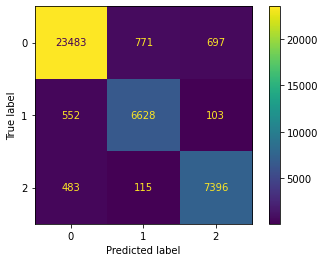

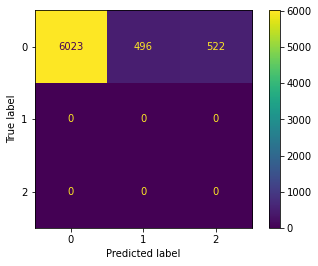

In [52]:
# training dataset testing
for t in ['Cap', 'pH5.2']:
    feats = []
    labels = []
    for i in range(len(x)):
        if treatments[i].find(t)!=-1:
            feats.append(x_trains[i])
            labels.append(y_trains[i])
    feat = np.concatenate(feats)
    label = np.concatenate(labels)
    # print(len(feats))
    print(t+' train accuracy = ', model.score(feat,label))
# testing dataset testing
for t in ['Cap', 'pH5.2', 'pH7.4']:
    feats = []
    labels = []
    for i in range(len(x)):
        if treatments[i].find(t)!=-1:
            feats.append(x_tests[i])
            labels.append(y_tests[i])
    # print(len(feats))
    feat = np.concatenate(feats)
    label = np.concatenate(labels)
    print(t+' test accuracy = ', model.score(feat,label))
# ALL confusion matrix 
feat = np.concatenate(x)
label = np.concatenate(y)
pred = model.predict(feat)
cm = confusion_matrix(label, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
# pH7.4 confusion matrix
feats = []
labels = []
for i in range(len(x)):
    if treatments[i].find('pH7.4')!=-1:
        feats.append(x_tests[i])
        labels.append(y_tests[i])
feat = np.concatenate(feats)
label = np.concatenate(labels)
pred = model.predict(feat)
cm = confusion_matrix(label, pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

### Regression

In [ ]:
# training model
model = SVR(kernel='rbf', C=100)
model = model.fit(x_train,y_train)
joblib.dump(model,'./data/models/f6.reg1')

In [19]:
def pred_data(datacls, treatments,x_trains,x_tests):
    feats = []
    labels = []
    for i in range(len(x)):
        if treatments[i]==datacls:
            feats.append(x_tests[i])
    feat = np.concatenate(feats)
    pred = model.predict(feat)
    return pred

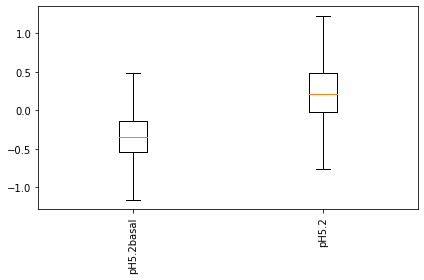

In [20]:
model = joblib.load('./data/models/f6.reg1')
pred_types = ['pH5.2basal','pH5.2']#['Capbasal','Cap','pH7.4basal','pH7.4',]
preds=[]
for treatment in pred_types:
    preds.append(pred_data(treatment, treatments,x_trains,x_tests))
plt.boxplot(preds, labels=pred_types, showfliers=False)
plt.xticks(rotation=90)
plt.tight_layout()